# 01. Dimensionality reduction

In [ ]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

<div class="alert alert-block alert-info"> <b>NOTE</b> Use blue boxes for Tips and notes. </div>

<div class='alert alert-block alert-info'>

Lesson time: 90 m   
Contributors: 

---
### In this lesson you will learn:
- What dimensionality reduction is and why it is useful in the analysis of neural data
- How to use Principal Component Analysis to obtain a low-dimensional description of the data
- How dimensionality reduction can be used to discover collective modes of activity in the brain
- You will get an overview of the most used non-linear dimensionality reduction methods

</div>


## Introduction
---
 
Data is often high dimensional. In the case of neural data, scientists routinely to make sense of the simultaneous activity of hundreds of recorded neurons.
Working with high dimensional data is difficult : we cannot visualize directly what is going on, and our statistical intuitions easily beak down (see, for example).  
Moreover, often the many dimensions in which the data live are not independent. Neurons have common inputs and talk to each other, neighboring pixels and voxels in imaging data are highly correlated.  
Dimensionality reduction methods yield a low-dimensional description of the data that retains important information, so that we can make sense of it more easily.
Common uses of dimensionality reduction are: 
- visualization: to visualize the data in a 2D or 3D space and get an intuitive feeling of some underlying structure
- compression: to efficiently describe the data without loosing to much information
- Preprocessing: to prepare the data for further analysis
- analysis: to discover and study collective modes of variation in the data


## Principal Component Analysis
---

Principal component analysis is one of the most popular dimensionality reduction algorithms. It performs **linear orthogonal transformation** of the data space that finds the combinations of features that best explain the variability of the data. These combinations, called **principal components**, form a new coordinate system for the data, such that the coordinates are ranked by explained variance.  

Here is a brief overview of how PCA works:  
Let's consider a $N\times P$ data matrix $X$ with $P$ features and $N$ observations (often referred to as "samples" in the data science literature).  
These are $N$ points $x_{i}$ in a  $P$-dimensional space.  

To find the first principal component, the algorithm looks for a $P$-dimensional weight vector $w_{1}$, with unit norm ($|w_{1}=1|$), such that the sum of the projections of the $N$ observed points $x_{i}$ in the direction $w_{1}$ is maximal:

$$ w_{1}=\underset{|w|=1} {argmax}\left[  \sum_{i=1}^{N}(x_{i} \cdot w)^{2} \right] = \underset{|w|=1} {argmax}\left[ w^{T}X^{T}Xw \right] $$

This finds the first principal component $w_{1}$, i.e. the direction of maximal variability in the feature space.  
We can repeat the procedure to find a second direction $w_{2}$, that maximizes variability on the $P-1$ dimensional subspace  $\hat{X}$ orthogonal to $w_{1}$.
We first find $\hat{X}$ by subtracting the first principal component from $X$:

$$ \hat{X}= X -Xw_{1}w_{1}^{T} $$

And then find $w_{2}$ maximizig projections in $\hat{X}$:

$$ w_{2} = \underset{|w|=1} {argmax}\left[ w^{T}\hat{X}^{T}\hat{X}w \right] $$

Repeating the procedure, we can iteratively found an orthonormal basis for the features space, in which dimensions are ranked by how variable the observed data are along them.
This ranking can be used to reduce the dimensionality of the data: we can decide to retain only the first $L$ components ($L<P$), we obtain a $L$ dimensional description of $X$. The PCA procedure guarantees that this representation i the one that captures the most variance of the data, given $L$.

### PCA in action: compressing images

In [35]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns


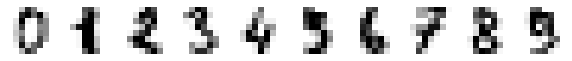

In [30]:
# load image data
dataset = load_digits()
images = dataset.data

#plot first 10 images
plt.figure(figsize=(10,5))
for i,img in enumerate(images[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')
    


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(images)

In [47]:
pca = PCA()
pca.fit(X)

PCA()

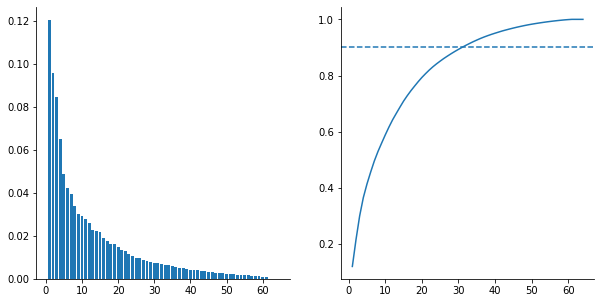

In [58]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(np.arange(1,len(pca.components_)+1),pca.explained_variance_ratio_)
sns.despine()
plt.subplot(1,2,2)
plt.plot(np.arange(1,len(pca.components_)+1),np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9,linestyle='--')
sns.despine()

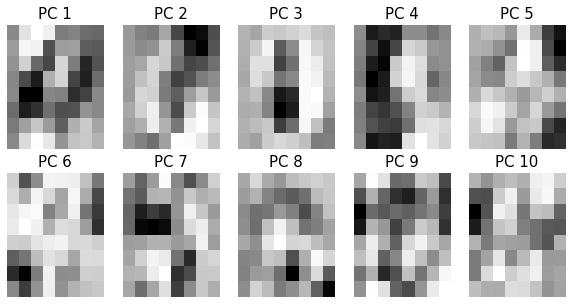

In [85]:
plt.figure(figsize=(10,5))
for i,component in enumerate(pca.components_[:10]):
    plt.subplot(2,5,i+1)
    plt.title(f'PC {i+1}',fontsize=15)
    plt.imshow(component.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')

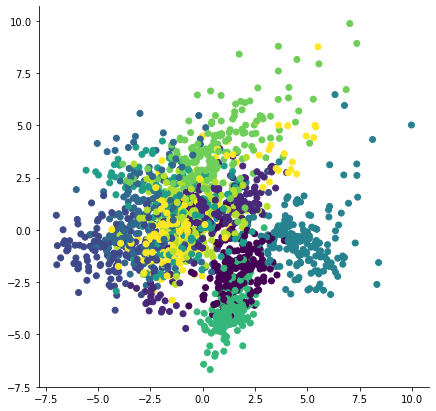

In [75]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.figure(figsize=(7,7))
plt.scatter(X_2d[:,0],X_2d[:,1],c=dataset.target)
sns.despine()

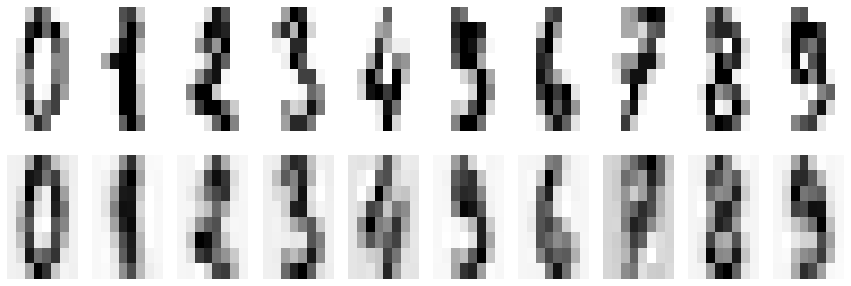

In [84]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_reduced)

reconstructed_images = scaler.inverse_transform(X_reconstructed)

n_examples = 10 
plt.figure(figsize=(15,5))
for i,(img,r_img) in enumerate(zip(images[:n_examples],reconstructed_images[:n_examples])):
    plt.subplot(2,n_examples,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')

    plt.subplot(2,10,i+11)
    plt.imshow(r_img.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')





### Example: discovering collective modes of cortical activity
---
As an example, we will look at how PCA can help us discover collective mode of activity in the mouse cortex.
Here you see a gif of the activity recorded from the dorsal right emisphere of a mouse, using [voltage sensitive dye imaging](https://www.mdpi.com/1422-0067/23/12/6814).


<img src="imgs/cortical_activity.gif" width="600">


As you can see, the activity in each pixel is far from independent.
Can we obtain a low-d description of the data? Let's apply PCA.

In [ ]:
# imports 
# load and descibe data

To apply PCA, we will use the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation.

In [ ]:
# apply PCA
# plot EVR and cumulative EVR


We see that the first 10 components explain roughly XX% of the variance. What do they look like?
Let's plot the weithts of each PC.

In [ ]:
# plot weights

We see that we can identify some clusters of activity. DESCRIBE  
Is any of these mode associated to the behaviour of the animal?  
This data was recorded while the animal was performing an [auditory trance conditioning task](paper_rafa).  
We have, for example, the time stamp at which the animal licks for reward. 
Does any cortical mode respond to licking? Let's plot the data aligned to licking time.


## Non-linear dimensionality reduction
---

<div class="warning" style='padding:0.5em; background-color:#f1f1f1;border:1px solid black;width:95%'>

### Key points 

- PCA performs a linear transformation on the data space, such that the axis of the new basis are ordered by decreasing explained variance
- PCA can help to obtain a lower-dimensional description of high-dimensional, correlated data
- MDS,Isomap and Umap are popular *distance based* dimensionality reduction methods

<div class="warning" style='padding:0.5em; background-color:#f1f1f1;border:1px solid black;width:95%'>

### References and resources

**Books**
* [The elements of statistical learning](https://hastie.su.domains/ElemStatLearn/#:~:text=Elements%20of%20Statistical%20Learning%3A%20data%20mining%2C%20inference%2C%20and%20prediction.), chapter 14

**Web**
* [PCA wiki](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [PCA, video lesson](https://www.youtube.com/watch?v=fkf4IBRSeEc&t=22s)


## Exercises
You can find the exercises for this lessons in [lesson1-exercises.ipynb](lesson1-exercises.ipynb)